# K-Nearest Neighbors (KNN) - Scikit-Learn Implementation

Multi-class classification on the **Covertype (Forest Cover Type)** dataset.

**Dataset**: 581,012 samples, 54 features, 7 forest cover types  
**Task**: Predict forest cover type from cartographic variables  
**Key Concept**: KNN is a "lazy learner" - no training phase, expensive at prediction time

## What Makes KNN Different?
- **Non-parametric**: Doesn't learn weights/coefficients like Logistic Regression
- **Instance-based**: Stores entire training set, compares at prediction time
- **Distance-based**: Classification depends on "nearest" training examples
- **No training**: All computation happens during prediction (O(n) per sample)


In [1]:
# Standard libraries
import numpy as np
import sys

# Scikit-Learn KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Add utils to path
sys.path.append('../..')
from utils.data_loader import load_processed_data
from utils.metrics import accuracy, macro_f1_score, confusion_matrix_multiclass
from utils.visualization import (
    plot_confusion_matrix_multiclass,
    plot_validation_curve,
    plot_per_class_f1
)
from utils.performance import track_performance

print("Imports complete!")

Imports complete!


In [2]:
# Load preprocessed data
"""
Data was preprocessed in data-preperation/preprocess_knn.py
    - 581,012 total samples (80/20 split)
    - StandardScaler applied (fit on train only)
    - All 4 frameworks load identical data for fair comparison
"""

X_train, X_test, y_train, y_test, metadata = load_processed_data('knn')

# Extract metadata for refernce
class_names = metadata['class_names']
n_classes = metadata['n_classes']
random_seed = metadata['random_seed']

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Classes ({n_classes}): {class_names}")
print(f"Random seed: {random_seed}")

Training set: 464,809 samples, 54 features
Test set: 116,203 samples
Classes (7): ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
Random seed: 113


## K-Value Tuning

The most important hyperparameter in KNN is **K** (number of neighbors).

**Bias-Variance Tradeoff:**
- **K=1**: High variance (overfitting) - prediction based on single nearest neighbor
- **K=large**: High bias (underfitting) - prediction averaged over many neighbors

We'll test K = 1, 3, 5, 7, 9, 11, 13, 15 and plot the validation curve.

In [3]:
# K-Value Tunning
"""
Test different K values to find optimal number of neighbors
Using accuracy on test set for each K value
"""

k_values = [1, 3, 5, 7, 9 , 11, 13, 15]
train_scores = []       # Accuracy on training set (to check overfitting)
test_scores = []        # Accuracy on test set (what really matters)

print("K-Value Tuning Progress:")
print("-" * 50)

for k in k_values:
    # Create and "fit" model (KNN just stores data, no real training)
    model = KNeighborsClassifier(n_neighbors=k, algorithm='auto', n_jobs=-1)
    model.fit(X_train, y_train)

    # Evaluate on both sets
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_acc = accuracy(y_train, train_pred)
    test_acc = accuracy(y_test, test_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)

    print(f"K={k:2d} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# Find best k
best_idx = np.argmax(test_scores)
best_k = k_values[best_idx]
print("-" * 40)
print(f"Best K: {best_k} (Test Accuracy: {test_scores[best_idx]:.4f})")


K-Value Tuning Progress:
--------------------------------------------------
K= 1 | Train Acc: 1.0000 | Test Acc: 0.9353
K= 3 | Train Acc: 0.9691 | Test Acc: 0.9331
K= 5 | Train Acc: 0.9560 | Test Acc: 0.9275
K= 7 | Train Acc: 0.9468 | Test Acc: 0.9228
K= 9 | Train Acc: 0.9394 | Test Acc: 0.9186
K=11 | Train Acc: 0.9330 | Test Acc: 0.9141
K=13 | Train Acc: 0.9278 | Test Acc: 0.9100
K=15 | Train Acc: 0.9230 | Test Acc: 0.9070
----------------------------------------
Best K: 1 (Test Accuracy: 0.9353)


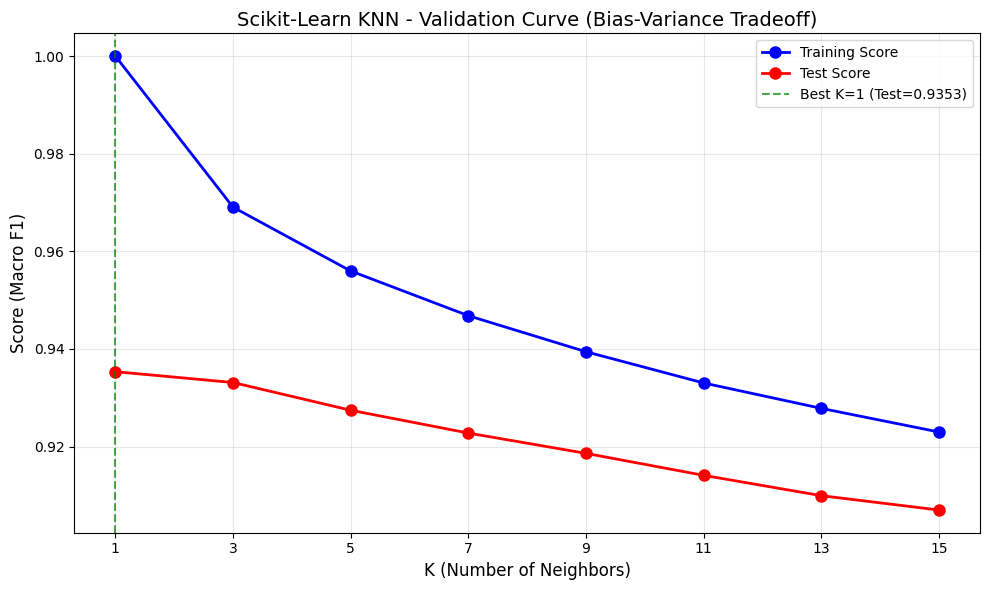

In [4]:
# Visualize K-value tuning

# Plot train vs test accuracy to see bias-variance tradeoff

plot_validation_curve(
    k_values=k_values,
    train_scores=train_scores,
    test_scores=test_scores,
    framework='Scikit-Learn KNN',
    save_path='results/validation_curve.png'
)

## GridSearchCV - Full Hyperparameter Tuning

Beyond just K, we can tune:
- **metric**: Distance function (euclidean vs manhattan)
- **weights**: How neighbors vote (uniform vs distance-weighted)

Using 5-fold cross-validation to find the best combination.


In [5]:
# GridSearchCV - Full Hyperparameter tuning

"""
Tune K, distance metric, and voting weights using cross-validation
This is more rigorous than the manual k-tuning loop
"""

param_grid = {
    'n_neighbors': [1, 3, 5, 7],            # K values (reduced for speed)
    'metric': ['euclidean', 'manhattan'],   # Distance functions
    'weights': ['uniform', 'distance']      # Voting: equal vs closer=stronger
}

print("Starting GridSearchCV (5-fold CV)...")
print("This may take several minutes with 464k samples...")
print("-" * 50)

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(algorithm='auto', n_jobs=-1),
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # Optimize for accuracy
    verbose=1,              # Show progress
    n_jobs=-1               # Use all CPU cores
)

grid_search.fit(X_train, y_train)

print("-" * 50)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV (5-fold CV)...
This may take several minutes with 464k samples...
--------------------------------------------------
Fitting 5 folds for each of 16 candidates, totalling 80 fits
--------------------------------------------------
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV Score: 0.9334


In [8]:
# Final Model With Best Parameters

# Train final model with GridSearchCV best parameters

best_params = grid_search.best_params_
print(f"Training final model with: {best_params}")

final_model = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    metric=best_params['metric'],
    weights=best_params['weights'],
    algorithm='auto',
    n_jobs=-1
)

# "Fit" the model (KNN just stores the data)
final_model.fit(X_train, y_train)

# Make predictions with performance tracking
with track_performance() as perf:
    y_pred = final_model.predict(X_test)

print(f"Prediction time: {perf['time']:.2f} seconds")
print(f"Peak memory: {perf['memory']:.2f} MB")
print(f"Predictions per second: {len(X_test)/perf['time']:,.0f}")

Training final model with: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Prediction time: 53.06 seconds
Peak memory: 19.40 MB
Predictions per second: 2,190


## Model Evaluation

Evaluating final model with:
- **Accuracy**: Overall correct predictions
- **Macro F1**: Average F1 across all 7 classes (treats each class equally)
- **Confusion Matrix**: 7x7 breakdown of predictions vs actual
- **Per-Class F1**: Identify which forest types are hardest to classify

In [ ]:
# Model Evaluation

# Calculate metrics
test_acc = accuracy(y_test, y_pred)
macro_f1, per_class_f1 = macro_f1_score(y_test, y_pred, return_per_class=True) # type: ignore

print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Macro F1 Score: {macro_f1:.4f}")
print()
print("Per-Class F1 Scores:")
print("-" * 30)
for i, (name, f1) in enumerate(zip(class_names, per_class_f1)):
    print(f"  {name:<20}: {f1:.4f}")

FINAL MODEL PERFORMANCE
Test Accuracy: 0.9377 (93.77%)
Macro F1 Score: 0.8935

Per-Class F1 Scores:
------------------------------
  Spruce/Fir          : 0.9386
  Lodgepole Pine      : 0.9481
  Ponderosa Pine      : 0.9199
  Cottonwood/Willow   : 0.8136
  Aspen               : 0.8276
  Douglas-fir         : 0.8566
  Krummholz           : 0.9501
